## 모델_1 긍정/부정 분류에 사용해볼 전처리
- macab 토큰화 후에 적용
- 불용어제거
- 임베딩층에 fasttext적용


In [1]:
import re
import pickle
# import chardet
import numpy as np
import pandas as pd
from collections import Counter
from soynlp.normalizer import repeat_normalize
from sklearn.feature_extraction.text import TfidfVectorizer

#텐서플로우
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

#필요없는 경고무시
import warnings
warnings.filterwarnings('ignore')

#시각화용 임포트 모음
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go

In [2]:
file_path='../../Data Set/모델_1_커스텀 감성분류.xlsx'
df_train = pd.read_excel(file_path)[::8]

df_train

,text,sentiment
0,슈밤 윈8에서는 잘돌아가더니 윈10에서 실행하니 튕기네 dlc사자마자 돌리니...,0
8,망겜 ㅇㅇ,0
16,진짜 지루함,0
24,즐딸.어이없다,1
32,중딩 때 극장에서 재밌게 봤던 기억ㅇㅣ,1
...,...,...
216056,너무귀여워요ㅎ 택도 겉에있어서 좋네요,1
216064,좀비보다 사람이 무서운 게임,1
216072,자동 생산하기 시작하니까 뿌듯함 ㅋㅋ,1
216080,김시진핑4퇴해라고4점 개꼴데정신차리고4강가라고4점,0


In [3]:
# 데이터프레임 확인
df_train

,text,sentiment
0,슈밤 윈8에서는 잘돌아가더니 윈10에서 실행하니 튕기네 dlc사자마자 돌리니...,0
8,망겜 ㅇㅇ,0
16,진짜 지루함,0
24,즐딸.어이없다,1
32,중딩 때 극장에서 재밌게 봤던 기억ㅇㅣ,1
...,...,...
216056,너무귀여워요ㅎ 택도 겉에있어서 좋네요,1
216064,좀비보다 사람이 무서운 게임,1
216072,자동 생산하기 시작하니까 뿌듯함 ㅋㅋ,1
216080,김시진핑4퇴해라고4점 개꼴데정신차리고4강가라고4점,0


In [4]:
def clean_korean_text(text):
    if isinstance(text, str): # 입력값이 문자열인 경우에만 함수 적용
        # 특수 문자 및 숫자 제거
        text = re.sub(r'[^가-힣ㄱ-ㅎㅏ-ㅣ\s]', ' ', text)
        # 반복되는 자음, 모음 제거 (e.g., 'ㅋㅋㅋ' -> 'ㅋ')
        text = repeat_normalize(text, num_repeats=1)
        # 띄어쓰기 정규화 (연속된 공백 문자를 하나의 공백 문자로 변환)
        text = re.sub(r'\s+', ' ', text).strip()
    return text

df_train['text'] = df_train['text'].apply(lambda x: clean_korean_text(x) if isinstance(x, str) else x)


In [5]:
#빈문자열 존재 확인
empty_string_exists = any(df_train['text'].apply(lambda x: x == ""))

if empty_string_exists:
    print("빈 문자열이 존재합니다.")
else:
    print("빈 문자열이 없습니다.")

빈 문자열이 존재합니다.


In [6]:
#빈문자열제거
df_train.drop(df_train[df_train['text'] == ""].index, inplace=True)

empty_string_exists = any(df_train['text'].apply(lambda x: x == ""))
if empty_string_exists:
    print("빈 문자열이 존재합니다.")
else:
    print("빈 문자열이 없습니다.")

빈 문자열이 없습니다.


,sentiment,text
0,negative,13467
1,positive,13460


<AxesSubplot:xlabel='sentiment', ylabel='count'>

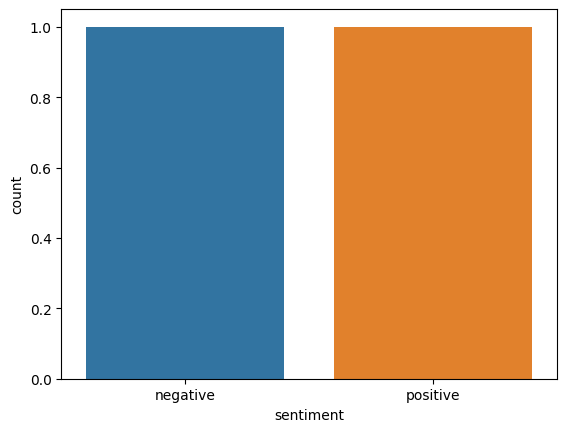

In [7]:
#긍정/부정 분포 시각화
temp = df_train.groupby('sentiment').count().reset_index().sort_values(by='text',ascending=False)
temp['sentiment']=temp['sentiment'].replace({0:'negative',1:'positive'})
display(temp)

# plt.figure(figsize=(12,6)) #크기조절
sns.countplot(x='sentiment',data=temp)

In [8]:
#정제된 텍스트를 mecab토큰화한다 ,여기서는 임시로 Okt
# from konlpy.tag import Okt
# mecab=Okt()

from konlpy.tag import Mecab
mecab=Mecab(dicpath=r'C:\mecab\mecab-ko-dic')
df_train['text'] = df_train['text'].apply(lambda x: mecab.morphs(str(x)))
df_train

,text,sentiment
0,"[슈, 밤, 윈, 에서, 는, 잘, 돌아가, 더니, 윈, 에서, 실행, 하, 니, ...",0
8,"[망, 겜, ㅇㅇ]",0
16,"[진짜, 지루, 함]",0
24,"[즐, 딸, 어이없, 다]",1
32,"[중, 딩, 때, 극장, 에서, 재밌, 게, 봤, 던, 기억, ㅇㅣ]",1
...,...,...
216056,"[너무, 귀여워, 요, ㅎ, 택, 도, 겉, 에, 있, 어서, 좋, 네요]",1
216064,"[좀, 비, 보다, 사람, 이, 무서운, 게임]",1
216072,"[자동, 생산, 하, 기, 시작, 하, 니까, 뿌듯, 함, ㅋㅋ]",1
216080,"[김, 시진핑, 퇴, 해, 라고, 점, 개꼴, 데, 정신, 차리, 고, 강가, 라고...",0


In [9]:
# 긍정/부정 공통으로 단어의 등장 빈도 수 순위
bindo = Counter([token for text in df_train['text'] for token in text])
df_count = pd.DataFrame.from_dict(bindo, orient='index', columns=['count']).sort_values('count', ascending=False)

#상위10 토큰만 출력
df_count.reset_index(inplace=True)
df_count.rename(columns={'index':'word'},inplace=True)
df_count[:10].style.background_gradient(cmap='Purples')

,word,count
0,이,14755
1,는,12089
2,고,11924
3,하,11604
4,도,7839
5,다,7186
6,가,7169
7,에,6589
8,은,6272
9,을,5314


In [10]:
# 불용어 정의
stop_words = ['좀','잘','과','도','을','를','으로','자','에','하다','고',
             '은', '는', '이', '가', '하', '아', '것', '들', '의', 
             '있', '되', '수', '보', '주', '등', '한', '더', '때', 
             '그', '그리고', '그래서', '그런데', '저', '너', '저희', 
             '그들', '제', '네', '이들', '저는', '제가', '저의', '너희', 
             '당신', '입니다', '많', '적', '보다', '적은', '많은','게임',
             '배송','영화','다','게','지']

#불용어 제거 적용
df_train['text'] = df_train['text'].apply(lambda x: ' '.join([word for word in x if word not in stop_words]).split() )
df_train[:10]


,text,sentiment
0,"[슈, 밤, 윈, 에서, 돌아가, 더니, 윈, 에서, 실행, 니, 튕기, 사, 자마...",0
8,"[망, 겜, ㅇㅇ]",0
16,"[진짜, 지루, 함]",0
24,"[즐, 딸, 어이없]",1
32,"[중, 딩, 극장, 에서, 재밌, 봤, 던, 기억, ㅇㅣ]",1
40,"[대체로, 평이, 한데, 그래픽, 하나, 만, 플레이, 할, 만, 가치, 어, 보입...",1
48,"[글, 로, 설명, 라고, 한마디, 로, 전설]",1
56,"[하녀, 괜찮, 봤, 는데, 너무, 실망, 연기, 최악, 특히, 김효진, 남자, 외...",0
64,"[퍼, 이상, 곡, 대부분, 중국어, 겜, 자체, 괜찮, 으나, 중국어, 보컬, 너...",0
72,[최고],1


In [11]:
#불용어 제거후 긍정/부정 공통으로 단어의 등장 빈도 수 순위
bindo = Counter([token for text in df_train['text'] for token in text])
df_count = pd.DataFrame.from_dict(bindo, orient='index', columns=['count']).sort_values('count', ascending=False)

#상위10 토큰만 출력
df_count.reset_index(inplace=True)
df_count.rename(columns={'index':'word'},inplace=True)
df_count[:10].style.background_gradient(cmap='Blues')

,word,count
0,좋,4906
1,네요,4310
2,는데,3799
3,안,3596
4,없,2999
5,너무,2739
6,습니다,2641
7,어요,2573
8,했,2479
9,만,2467


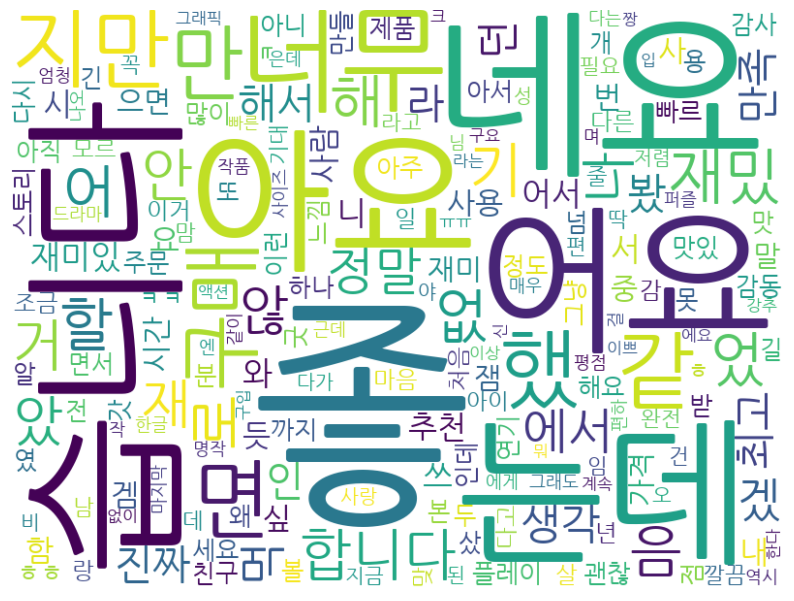

In [37]:
from wordcloud import WordCloud
import matplotlib.font_manager as fm

# 긍정 단어만 추출
positive_words = df_train[df_train['sentiment'] == 1]['text'].sum()

# 폰트 설정
font_path = './나눔고딕/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=16)

# 불용어 제거 후 긍정 단어 빈도수 계산
positive_word_count = Counter([token for token in positive_words if token not in stop_words])

# 워드 클라우드 생성
wordcloud = WordCloud(font_path=font_path, background_color='white', width=800, height=600).generate_from_frequencies(positive_word_count)

# 워드 클라우드 시각화
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


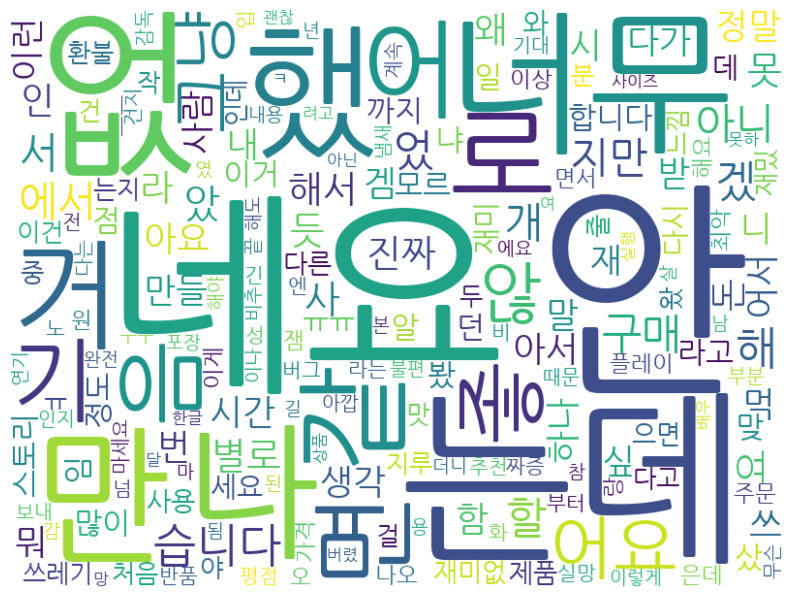

In [13]:
from wordcloud import WordCloud
import matplotlib.font_manager as fm
# 부정 단어만 추출
negetive_words = df_train[df_train['sentiment'] == 0]['text'].sum()

# 폰트 설정
font_path = './나눔고딕/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=16)

# 불용어 제거 후 부정 단어 빈도수 계산
negetive_word_count = Counter([token for token in negetive_words if token not in stop_words])

# 워드 클라우드 생성
wordcloud = WordCloud(font_path=font_path, background_color='white', width=800, height=600).generate_from_frequencies(negetive_word_count)

# 워드 클라우드 시각화
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [14]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in df_train['text']))
print('리뷰의 평균 길이 :',sum(map(len, df_train['text']))/len(df_train['text']))
print('리뷰의 90%를 포함하는 길이 :', df_train['text'].str.len().quantile(0.9) )


# 리뷰의 95%를 포함하는 길이
max_length = int(np.around(df_train['text'].str.len().quantile(0.95)))

#너무 긴 리뷰와 길이1 문자열을 삭제
df_train = df_train[(df_train['text'].str.len() >= 2) & (df_train['text'].str.len() <= max_length)]


리뷰의 최대 길이 : 60
리뷰의 평균 길이 : 13.116945816466744
리뷰의 90%를 포함하는 길이 : 29.0


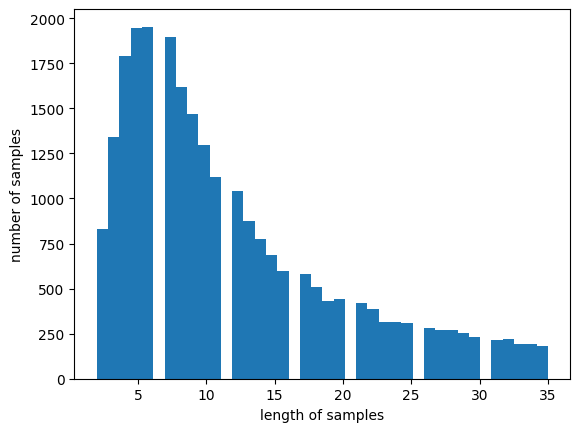

In [20]:
plt.hist([len(review) for review in df_train['text']], bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [21]:
# 35000개 = 실무에서 일반적으로 사용하는? 갯수
#cleaned_sentences의 빈도수 30000개 어절을 토크나이저에 fit시킴
vocab_size=32000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df_train['text'])

# tokenizer 객체를 저장
with open('GRU_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

#시퀀스데이터로 변환 ==벡터화
sequences = tokenizer.texts_to_sequences(df_train['text'])

In [22]:
#길이를 맞춰주는 패딩작업, 길이는 리뷰의 97%를 포함하는 길이로
x_train = pad_sequences(sequences, maxlen= max_length, padding='post')

In [23]:
#y값 추출, 데이터 차원 맞추기, 넘파이 배열로 변환
y_train=(df_train.iloc[:,1].to_frame()).to_numpy()
y_train

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]], dtype=int64)

In [24]:
#시퀀스 길이확인
print(x_train[0])
x_train.shape

[2801 1120 4250   30  940  244 4250   30  300   50  876   44  462 1061
   50    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]


(25243, 35)

패스트텍스트 학습해보기  => 임베딩층에 사전학습모델을 넣어주는것이다.

In [25]:
from gensim.models import FastText
#sg=1 : skipgram사용, 중심단어를 기준으로 주변단어예측
embedding_dim = 300
ft_model = FastText(df_train['text'],
                    vector_size=embedding_dim,
                    window=5, 
                    min_count=3, 
                    sg=1)

# 완성된 임베딩 매트릭스의 크기 확인
ft_model.wv.vectors.shape

(8049, 300)

In [32]:
#어떤 토큰과 유사도가 있는지 보지, OOV인 토큰을넣어도 쌉가능
print(ft_model.wv.most_similar("이수빈"))

[('똥', 0.14631468057632446), ('전', 0.12988197803497314), ('꼬', 0.12457647174596786), ('네여', 0.12076418101787567), ('작', 0.11951778829097748), ('별루', 0.11569836735725403), ('향', 0.1139453798532486), ('잡', 0.11347957700490952), ('짱', 0.11338145285844803), ('띵', 0.11281339824199677)]


In [ ]:
import io

# 벡터 파일 저장
with io.open('vectors.tsv', 'w', encoding='utf-8') as f:
    for word in ft_model.get_words():
        vec = ft_model.get_word_vector(word)
        vec_str = '\t'.join(str(x) for x in vec)
        f.write(f'{vec_str}\n')

# 메타데이터 파일 저장
with io.open('metadata.tsv', 'w', encoding='utf-8') as f:
    for word in ft_model.get_words():
        f.write(f'{word}\n')

In [122]:
# 학습된 입베딩층 모델 저장
# ft_model.save("FT_LSTM_test.bin")

In [123]:
# FastText 임베딩 로드
# import fasttext
# fasttext_model = FastText.load('./FT_LSTM_test.bin')

In [33]:
tokenizer.word_index.items()

dict_items([('좋', 1), ('네요', 2), ('는데', 3), ('안', 4), ('없', 5), ('너무', 6), ('어요', 7), ('습니다', 8), ('만', 9), ('했', 10), ('같', 11), ('나', 12), ('면', 13), ('아요', 14), ('어', 15), ('기', 16), ('로', 17), ('거', 18), ('음', 19), ('지만', 20), ('구매', 21), ('었', 22), ('해', 23), ('않', 24), ('할', 25), ('재밌', 26), ('았', 27), ('합니다', 28), ('겠', 29), ('에서', 30), ('재', 31), ('정말', 32), ('그냥', 33), ('서', 34), ('요', 35), ('해서', 36), ('진짜', 37), ('먹', 38), ('라', 39), ('아니', 40), ('개', 41), ('인', 42), ('생각', 43), ('사', 44), ('쓰', 45), ('어서', 46), ('듯', 47), ('봤', 48), ('내', 49), ('니', 50), ('던', 51), ('시간', 52), ('함', 53), ('겜', 54), ('말', 55), ('시', 56), ('못', 57), ('왜', 58), ('아서', 59), ('싶', 60), ('번', 61), ('사람', 62), ('와', 63), ('받', 64), ('사용', 65), ('점', 66), ('재미', 67), ('별로', 68), ('많이', 69), ('스토리', 70), ('재미있', 71), ('세요', 72), ('까지', 73), ('최고', 74), ('으면', 75), ('중', 76), ('이런', 77), ('추천', 78), ('뭐', 79), ('이거', 80), ('하나', 81), ('알', 82), ('만들', 83), ('잼', 84), ('만족', 85), ('해요', 86), ('가격', 87

In [34]:
ft_model.wv['영화']

array([ 0.11466745, -0.04499032, -0.10463027, -0.03410766, -0.08456579,
       -0.09579075, -0.06131883,  0.2879829 , -0.06180135,  0.14167738,
        0.05334844, -0.05248811, -0.01935166, -0.08611   , -0.25225556,
        0.17664568, -0.02484868,  0.00787596,  0.03802624, -0.11600506,
        0.01724595,  0.02131066,  0.04498619,  0.01508642,  0.19932278,
        0.02200759, -0.03923325, -0.08024024, -0.18090087, -0.15223572,
       -0.13110535,  0.07720611,  0.02969381, -0.01392568, -0.07619346,
        0.00229676,  0.00653914, -0.12945843,  0.06050823, -0.04939264,
        0.01719708,  0.0028698 , -0.08703097, -0.01687121,  0.06448429,
        0.18345709,  0.24405766,  0.09121748, -0.0597513 ,  0.1116508 ,
       -0.04171408, -0.05102445, -0.07757015, -0.01181905,  0.09093802,
       -0.0782317 ,  0.02533475,  0.01156096, -0.07853796, -0.04861   ,
       -0.14490743, -0.08266965,  0.06569158, -0.1539045 ,  0.10190173,
        0.09206567,  0.19896059, -0.06310422, -0.03488152, -0.21

In [35]:
# 임베딩 매트릭스 생성
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = ft_model.wv[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
#전처리끝 모델시작

## RNN계열 모델 가져와서 학습시키기

In [37]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, GRU, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

def create_model(dropout_rate=0.3, neurons=64, learning_rate=0.001):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False),
        Bidirectional(GRU(neurons, dropout=dropout_rate, recurrent_dropout=dropout_rate)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=64, verbose=0)

param_distributions = {
    'dropout_rate': uniform(loc=0.1, scale=0.4),
    'neurons': [32, 64, 128],
    'learning_rate': uniform(loc=0.001, scale=0.099),
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=20, n_jobs=-1, cv=3)
random_search_result = random_search.fit(x_train, y_train)

print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))

# 최적의 하이퍼파라미터로 훈련된 모델 저장
best_model = random_search_result.best_estimator_.model
best_model.save('GRU_model_2.h5')

In [ ]:
# 최적의 하이퍼파라미터 분포 그래프
import matplotlib.pyplot as plt

results = pd.DataFrame(random_search_result.cv_results_)
params = results[['param_dropout_rate', 'param_neurons', 'param_learning_rate']]
mean_scores = results['mean_test_score']

plt.figure(figsize=(12, 6))
plt.scatter(range(len(mean_scores)), mean_scores, c=mean_scores, cmap='viridis')
plt.xlabel("Parameter set index")
plt.ylabel("Mean score")
plt.colorbar(label='Mean score')
plt.show()

In [ ]:
# 학습 곡선 시각화
history = best_model.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# model.save('GRU_model_1.h5')

In [ ]:
keras.utils.plot_model(model,show_shapes=True)